<a href="https://colab.research.google.com/github/LSSTISSC/Tidalsaurus/blob/main/notebooks/Self_Supervised_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Learning on HSC images

Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)

In this notebook, we will demonstrate the use of a simple contrastive learning strategy ( [SimSiam, Chen & He, 2020](https://arxiv.org/abs/2011.10566)) to build a self-supervised representation for HSC images.

Relevant papers:
- Exploring Simple Siamese Representation Learning https://arxiv.org/abs/2011.10566
- Self-Supervised Representation Learning for Astronomical Images https://arxiv.org/abs/2012.13083

Relevant material:
- Keras example for SSL: https://keras.io/examples/vision/simsiam/


In [ ]:
# Retrieving pre-prepared data, it takes 2 minutes.
!gsutil -m -q cp -r gs://ahw2019/hsc_photoz/tensorflow_datasets /root/ 

In [ ]:
# Retrieving utilities
!git clone https://github.com/EiffL/Tutorials.git

In [ ]:
# Install dependencies
!pip install --user tensorflow-addons

#### Checking for GPU

In [ ]:
import tensorflow as tf

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Loading dataset

In [ ]:
%cd Tutorials/PhotozCNN
import tensorflow_datasets as tfds
import hsc_photoz

hsc_dset = tfds.load('hsc_photoz', split='train')

Populating the interactive namespace from numpy and matplotlib


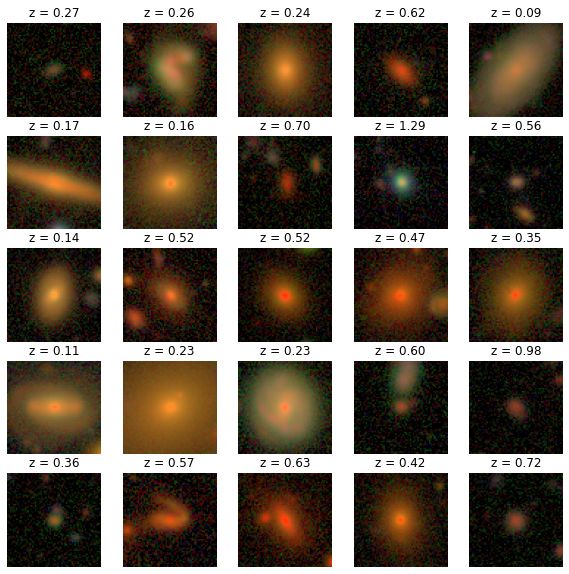

In [ ]:
from astropy.visualization import make_lupton_rgb
%pylab inline 

# The data is in 5 bands GRIZY, but for visualisation we use only the
# 3 first bands and luptonize them
def luptonize(img):
  return make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0],
                         Q=15, stretch=0.5, minimum=0)

plt.figure(figsize=(10,10))
for i, entry in enumerate(hsc_dset.take(25)):
  plt.subplot(5,5,i+1)
  plt.imshow(luptonize(entry['image']))
  plt.title('z = %0.02f'%entry['attrs']['specz_redshift'])
  plt.axis('off')

In [ ]:
entry['image'].shape

TensorShape([64, 64, 5])

In [ ]:
# Apply normalization to images
# Let's collect a few examples to check their distributions
cutouts=[]
for (batch, entry) in enumerate(hsc_dset.take(1000)):
  cutouts.append(entry['image'])
cutouts = np.stack(cutouts)

from astropy.stats import mad_std
scaling = []

for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  sigma = mad_std(cutouts[...,i].flatten())
  scaling.append(sigma)

def preprocessing(example):
  img = tf.math.asinh(example['image'] / tf.constant(scaling) / 3. )
  # We return the preprocessed images
  return img

def unnormalize(x):
  return tf.math.sinh(x) * tf.constant(scaling,dtype=tf.float32) * 3

normalized_hsc_dset = hsc_dset.map(preprocessing)

## Building data augmentation pipeline



In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5
CROP_TO = 60
SEED = 42

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

In [ ]:
import tensorflow_addons as tfa

def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 5))
    return image

def color_drop(x):
    x = tf.sqrt(tf.reduce_sum(x**2, axis=-1, keepdims=True))
    x = tf.tile(x, [1, 1, 5])
    return x

def add_noise(x):
    sigma = tf.random.uniform([], minval=0, maxval=0.5)
    x += sigma*tf.random.normal([64,64,5])
    return x

def add_blur(x):
    x = tfa.image.gaussian_filter2d(x, filter_shape=(3,3), sigma=1.)
    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = random_apply(add_noise, image, p=0.5)
    image = random_apply(color_drop, image, p=0.2)
    image = random_apply(add_blur, image, p=0.5)
    image = flip_random_crop(image)
    return image

Now we create 2 versions of the same dataset so that every image will be based on the same true HSC image, but receive different augmentations:

In [ ]:
# Build two versions of the dataset
dset_one = normalized_hsc_dset.shuffle(1024, seed=SEED)
dset_one = dset_one.map(custom_augment, num_parallel_calls=AUTO)
dset_one = dset_one.batch(BATCH_SIZE)
dset_one = dset_one.prefetch(AUTO)

dset_two = normalized_hsc_dset.shuffle(1024, seed=SEED)
dset_two = dset_two.map(custom_augment, num_parallel_calls=AUTO)
dset_two = dset_two.batch(BATCH_SIZE)
dset_two = dset_two.prefetch(AUTO)

In [ ]:
# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((dset_one, dset_two))

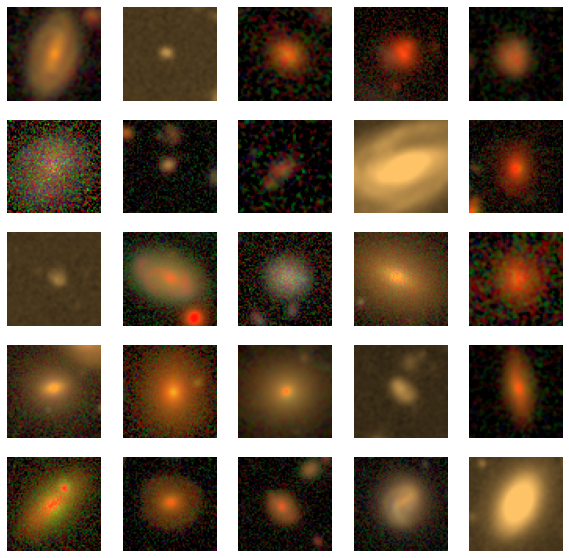

In [ ]:
# Visualize a few augmented images.
sample_images_one = next(iter(dset_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(luptonize(unnormalize(sample_images_one[n]).numpy()).astype("int"))
    plt.axis("off")
plt.show()


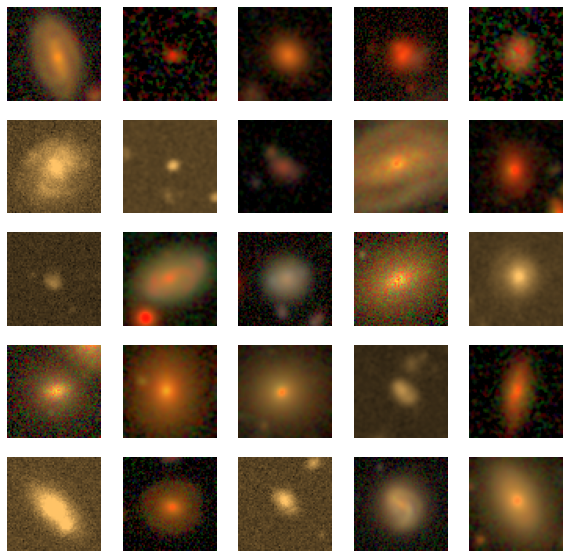

In [ ]:
sample_images_two = next(iter(dset_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(luptonize(unnormalize(sample_images_two[n]).numpy()).astype("int"))
    plt.axis("off")
plt.show()

We see that these two sets of images are based on the same true galaxies, but seen under different perturbations.

## Build the networks

Here, as a baseline, we follow the keras example from  https://keras.io/examples/vision/simsiam/

It is based on a resnet 20 network, which is not the biggest one we could imagine, but a good starting point.

In [ ]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [ ]:
import resnet_cifar10_v2
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as regularizers

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1

def get_encoder():
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 5))
    x = resnet_cifar10_v2.stem(inputs)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

This will be our loss function, which computes the similarity between pairs of encoded images:

In [ ]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

In [ ]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

## Training

In [ ]:
# Create a cosine decay learning scheduler.
num_training_samples = 20000
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

## Looking for similarity 


Now that the model is more or less trained, let's see if it is learning a usable representation.

We are going to use its latent representation to compute a similarity score between galaxy examples, and find the most similar ones to a given example.

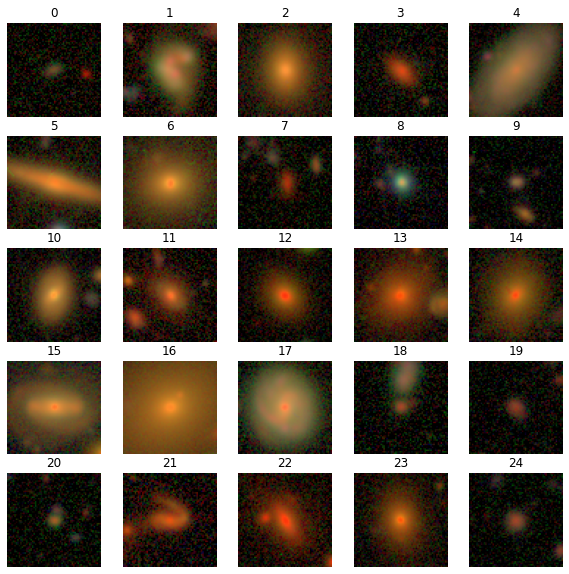

In [ ]:
# Let's find a galaxy that we will use to query
ims = []
plt.figure(figsize=(10,10))
for i, entry in enumerate(normalized_hsc_dset.take(25)):
  plt.subplot(5,5,i+1)
  plt.imshow(luptonize(unnormalize(entry)))
  ims.append(entry)
  plt.title(i)
  plt.axis('off')

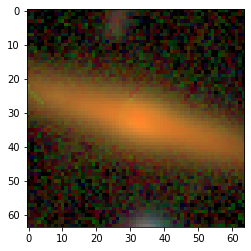

In [ ]:
# Ok, so say we want to find more of our favorite galaxy 
im_ref = ims[5]
imshow(luptonize(unnormalize(im_ref)))

In [ ]:
test_dset = normalized_hsc_dset.map(lambda x: tf.image.central_crop(x, CROP_TO/64.))
test_dset = test_dset.batch(256)

batch_ref = tf.expand_dims(tf.image.central_crop(im_ref, CROP_TO/64.), 0)

In [ ]:
@tf.function
def compute_similarity(p, z):
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return tf.reduce_sum((p * z), axis=1)

In [ ]:
similarity = []
ims = []
for batch in test_dset.take(20):
  similarity.append(compute_similarity(simsiam.encoder(batch_ref), simsiam.encoder(batch)))
  ims.append(batch.numpy())
similarity = np.concatenate(similarity)
ims = np.concatenate(ims, axis=0)

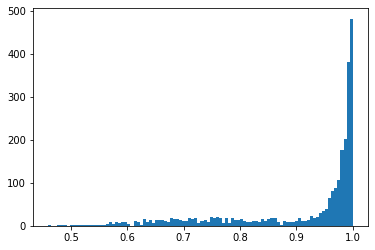

In [ ]:
hist(similarity,100);

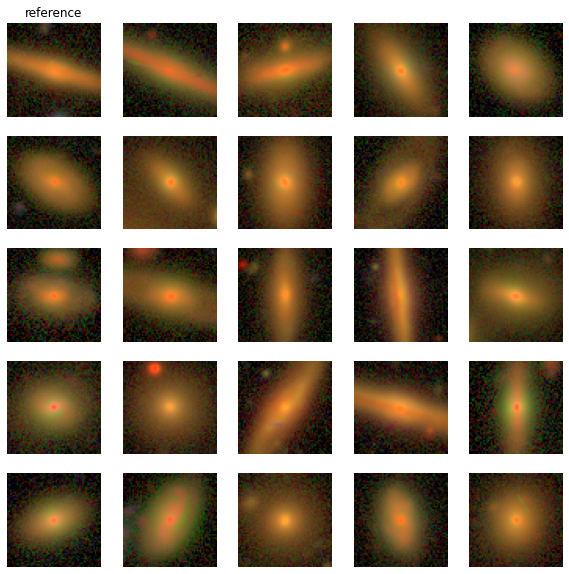

In [ ]:
# Looking at the 25 most similar galaxies
inds = argsort(similarity)[::-1]

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(luptonize(unnormalize(ims[inds[i]])))
  if i ==0:
    title('reference')
  plt.axis('off')

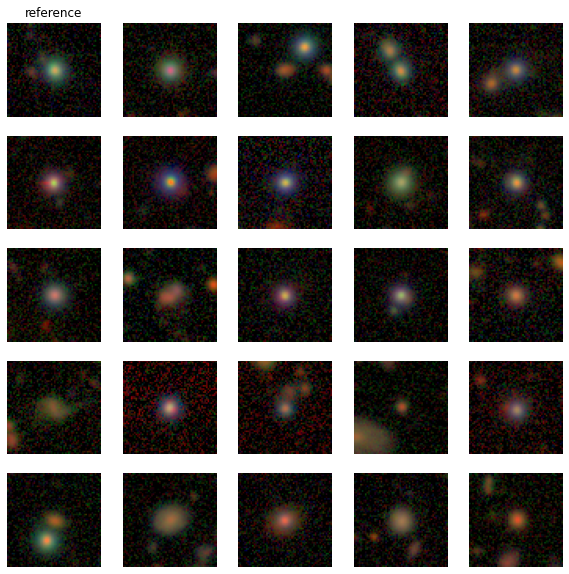

In [ ]:
# Looking at the 25 most similar galaxies
inds = argsort(similarity)[::-1]

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(luptonize(unnormalize(ims[inds[i]])))
  if i ==0:
    title('reference')
  plt.axis('off')

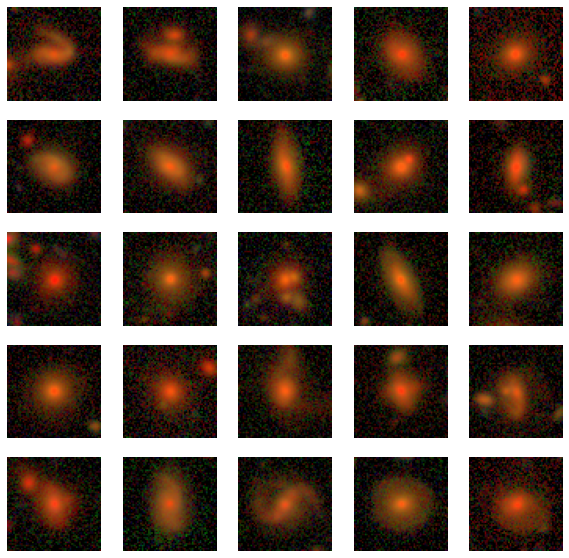

In [ ]:
# Looking at the 25 most similar galaxies
inds = argsort(similarity)[::-1]

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(luptonize(unnormalize(ims[inds[i]])))
  plt.axis('off')